## Recurrent Neural Networks:

Fake News Detection using Recurrent Neural Networks (RNNs) is a natural language processing (NLP) approach to automatically identify and classify fake news from genuine news articles. 
- The process involves data preparation, tokenizing and embedding the text, and designing an RNN-based architecture with LSTM or GRU layers to capture the sequential information.
- Train the model on a labeled dataset of fake and genuine news articles, optimizing using backpropagation and evaluation on a test set using metrics like accuracy, precision & recall.

RNNs are particularly effective for sequential data, like text, because they can capture dependencies and patterns within the text.

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
# The Tokenizer class is a text preprocessing tool that helps convert text 
# data into sequences of integers, which can be used as input for training 
# machine learning models, such as neural networks.
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
plt.style.use('ggplot')

In [2]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [5]:
true['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

The topics in `subject` column are different for both categories, hence we can exclude it from the final `fake` & `true` dataframes. 

In [6]:
fake.drop(['date', 'subject'], axis = 1, inplace = True)
true.drop(['date', 'subject'], axis = 1, inplace = True)
fake['Label'] = 0
true['Label'] = 1

Check the distribution of Fake News compared to Real News.

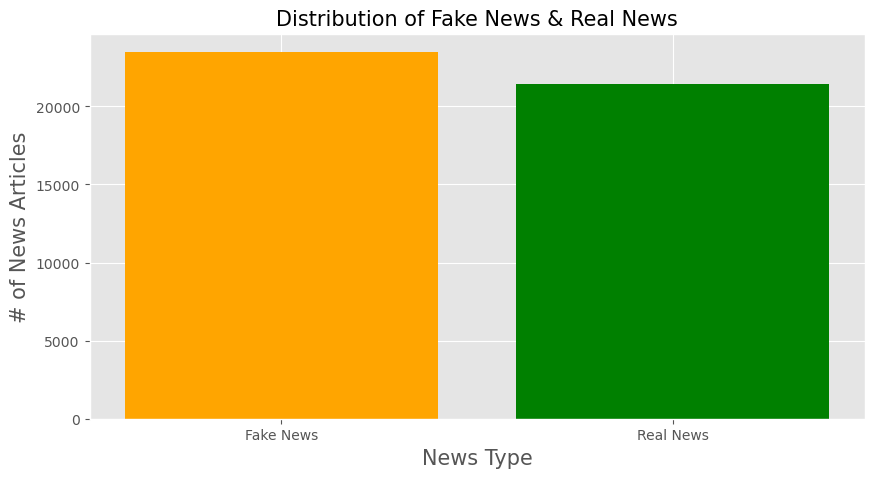

In [7]:
plt.figure(figsize = (10, 5))
plt.bar('Fake News', len(fake), color = 'orange')
plt.bar('Real News', len(true), color = 'green')
plt.title('Distribution of Fake News & Real News', size = 15)
plt.xlabel('News Type', size = 15)
plt.ylabel('# of News Articles', size = 15)
plt.show()

In [8]:
df = pd.concat([fake, true], ignore_index = True, sort = False)
df = shuffle(df).reset_index(drop = True)
df.head()

,title,text,Label
0,Kellyanne Conway Embarrasses Herself During C...,Kellyanne Conway was sent to meet with congres...,0
1,U.N. vote a resounding global 'No' to U.S. int...,Ankara (Reuters) - The United Nations General ...,1
2,ANYONE WHO Still Supports Hillary After They S...,"Hillary is without a doubt, the worst and most...",0
3,SUPREME COURT AGREES TO TAKE ON Obama’s Un-Ame...,"So far, the Supreme Court has not prevented on...",0
4,UCLA PLAYER’S FATHER Disses Trump On China Rel...,Send this kid back to China! The ungrateful at...,0


In [9]:
df['text'] = df['title'] + df['text']
df.drop('title', axis = 1, inplace = True)
df.head()

,text,Label
0,Kellyanne Conway Embarrasses Herself During C...,0
1,U.N. vote a resounding global 'No' to U.S. int...,1
2,ANYONE WHO Still Supports Hillary After They S...,0
3,SUPREME COURT AGREES TO TAKE ON Obama’s Un-Ame...,0
4,UCLA PLAYER’S FATHER Disses Trump On China Rel...,0


### Model Evaluation:

In [10]:
features = df['text']
targets = df['Label']
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 18)

def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # Get rid of URLs:
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # Get rid of non words and extra spaces:
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

max_vocab = 10000
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(X_train)

In [11]:
# Tokenize the text into vectors:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Applying padding so we have the same length for each article:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding = 'post', maxlen = 256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding = 'post', maxlen = 256)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

We are going to use early stop, which stops when the validation loss no longer improve.

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.1, batch_size = 30, shuffle = True, callbacks = [early_stop])

Epoch 1/10
1078/1078 [==============================] - 331s 297ms/step - loss: 0.2554 - accuracy: 0.8834 - val_loss: 0.0705 - val_accuracy: 0.9777
Epoch 2/10
1078/1078 [==============================] - 333s 309ms/step - loss: 0.0489 - accuracy: 0.9878 - val_loss: 0.0459 - val_accuracy: 0.9883
Epoch 3/10
1078/1078 [==============================] - 321s 297ms/step - loss: 0.0260 - accuracy: 0.9941 - val_loss: 0.0351 - val_accuracy: 0.9900
Epoch 4/10
1078/1078 [==============================] - 325s 301ms/step - loss: 0.0136 - accuracy: 0.9970 - val_loss: 0.0349 - val_accuracy: 0.9911
Epoch 5/10
1078/1078 [==============================] - 325s 301ms/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 0.0386 - val_accuracy: 0.9891
Epoch 6/10
1078/1078 [==============================] - 329s 305ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0337 - val_accuracy: 0.9922
Epoch 7/10
1078/1078 [==============================] - 317s 294ms/step - loss: 0.0117 - accuracy: 0.9967 - val_

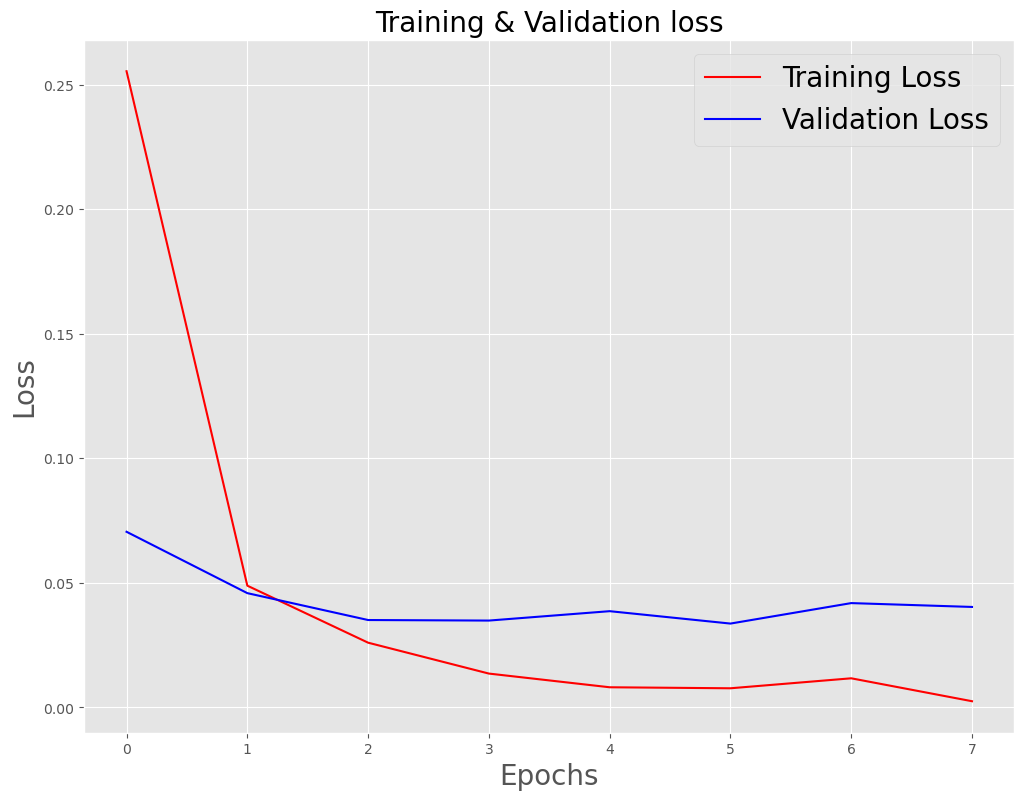

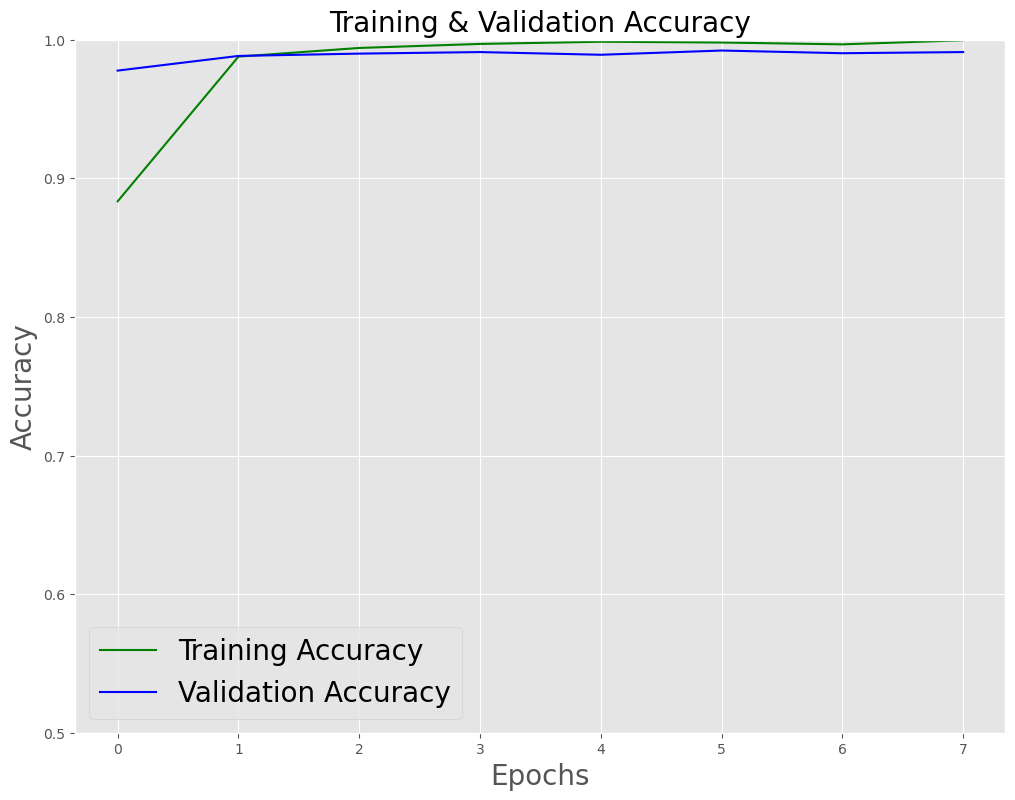

In [14]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize = (12, 9))
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training & Validation loss', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.legend(prop = {'size': 20})
plt.show()

plt.figure(figsize = (12, 9))
plt.plot(epochs, acc, 'g', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Accuracy', size = 20)
plt.legend(prop = {'size': 20})
plt.ylim((0.5, 1))
plt.show()

In [15]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 24s 84ms/step - loss: 0.0358 - accuracy: 0.9913


[0.03583159297704697, 0.9913140535354614]

In [17]:
pred = model.predict(X_test)
binary_predictions = []
for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)
print('Accuracy on Testing Set: {}%'.format(accuracy_score(binary_predictions, y_test)*100))
print('Precision on Testing Set: {}%'.format(precision_score(binary_predictions, y_test)*100))
print('Recall on Testing Set: {}%'.format(recall_score(binary_predictions, y_test)*100))

281/281 [==============================] - 24s 86ms/step
Accuracy on Testing Set: 99.13140311804008%
Precision on Testing Set: 98.96640826873386%
Recall on Testing Set: 99.19943489522015%


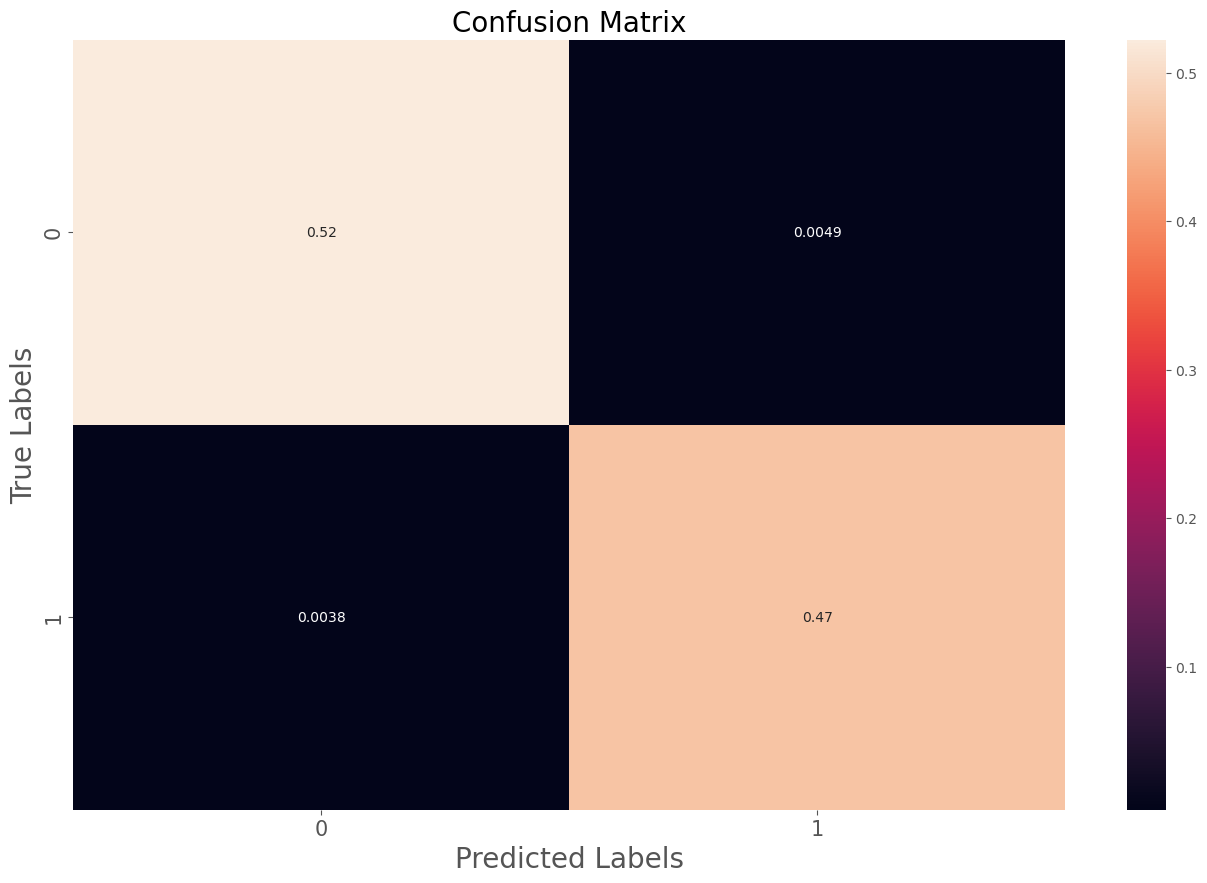

In [19]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# Labels, Title & Ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)
plt.show()